In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import sklearn

In [2]:
import xgboost as xgb

In [48]:
sns.set_theme(style="ticks", palette="pastel")

In [11]:
data2 = pd.read_csv("D:\data_set.csv",engine = "python")

In [12]:
data2.head()

,Unnamed: 0,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,new_condition
0,0,11555,2008,gmc,sierra 1500 extended cab,NaN,6 cylinders,gas,196372,clean,automatic,NaN,NaN,pickup,excellent
1,1,19995,2018,bmw,3 series,NaN,NaN,gas,31727,clean,automatic,NaN,NaN,NaN,good
2,2,12899,2013,honda,cr-v,NaN,4 cylinders,gas,97850,clean,automatic,NaN,NaN,SUV,good
3,3,16999,2010,ford,expedition,NaN,NaN,gas,128284,clean,automatic,4wd,NaN,NaN,good
4,4,16995,2013,bmw,3 series,NaN,6 cylinders,gas,103690,clean,automatic,4wd,NaN,NaN,good


In [103]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241520 entries, 0 to 245284
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     241520 non-null  int64 
 1   price          241520 non-null  int64 
 2   year           241520 non-null  int64 
 3   manufacturer   241520 non-null  object
 4   model          239175 non-null  object
 5   condition      148720 non-null  object
 6   cylinders      143223 non-null  object
 7   fuel           240503 non-null  object
 8   odometer       241520 non-null  int32 
 9   title_status   241520 non-null  object
 10  transmission   240576 non-null  object
 11  drive          170813 non-null  object
 12  size           67917 non-null   object
 13  type           191701 non-null  object
 14  new_condition  241520 non-null  object
dtypes: int32(1), int64(3), object(11)
memory usage: 38.6+ MB


# 데이터 전처리
- 제조사 상위 30개
- year 결측치 제거
- price 8만달러 이상 제거
- year 1980년까지
- title_status에서 part only는 버리기 / title_status 결측치
- odometer - 1,000,000km 위로는 버립시당  
    odometer의 결측치  
    odometer에 clean이라는 값  
- new_condtion의 결측치 

In [15]:
data2 = data2[~data2.year.isna()]

In [17]:
data2 = data2[data2.year >= 1980]

In [41]:
data2 = data2[data2.title_status != "parts_only"]
data2 = data2[~data2.isna()]

In [28]:
data2 = data2[~data2.odometer.isna()]

In [37]:
data2 = data2[~(data2.odometer == "clean")]

In [38]:
data2.odometer = data2.odometer.astype(int)

In [40]:
data2 = data2[data2.odometer < 1000000 ]

In [44]:
data2 = data2[~data2.new_condition.isna()]

In [104]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241520 entries, 0 to 245284
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     241520 non-null  int64 
 1   price          241520 non-null  int64 
 2   year           241520 non-null  int64 
 3   manufacturer   241520 non-null  object
 4   model          239175 non-null  object
 5   condition      148720 non-null  object
 6   cylinders      143223 non-null  object
 7   fuel           240503 non-null  object
 8   odometer       241520 non-null  int32 
 9   title_status   241520 non-null  object
 10  transmission   240576 non-null  object
 11  drive          170813 non-null  object
 12  size           67917 non-null   object
 13  type           191701 non-null  object
 14  new_condition  241520 non-null  object
dtypes: int32(1), int64(3), object(11)
memory usage: 38.6+ MB


In [45]:
y = data2.price

In [114]:
x = data2[["year","odometer"]]

In [113]:
dummies = pd.get_dummies(x[['manufacturer',"fuel","new_condition","drive","cylinders","size","type"]], dummy_na=True)

In [116]:
x = pd.concat([x,dummies],axis=1)

In [111]:
x

,year,manufacturer,fuel,odometer,new_condition,drive,cylinders,size,type
0,2008,gmc,gas,196372,excellent,NaN,6 cylinders,NaN,pickup
1,2018,bmw,gas,31727,good,NaN,NaN,NaN,NaN
2,2013,honda,gas,97850,good,NaN,4 cylinders,NaN,SUV
3,2010,ford,gas,128284,good,4wd,NaN,NaN,NaN
4,2013,bmw,gas,103690,good,4wd,6 cylinders,NaN,NaN
...,...,...,...,...,...,...,...,...,...
245280,2015,gmc,gas,35423,good,4wd,8 cylinders,NaN,pickup
245281,2004,chevrolet,gas,170000,good,NaN,8 cylinders,full-size,truck
245282,2014,toyota,other,55251,good,NaN,NaN,NaN,pickup
245283,2011,ford,gas,39325,excellent,4wd,NaN,NaN,NaN


In [118]:
train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=1234)

In [119]:
test_y

108220     1000
107217    31900
209144    48900
102840     5000
71672      9995
          ...  
61388     54999
239312    11999
82304     18089
194075     2800
69648     39995
Name: price, Length: 60380, dtype: int64

In [183]:
xgbc = xgb.XGBRegressor()

xgbc.fit(train_x,train_y)
xgbc.score(test_x,test_y)

0.816137983233932

In [208]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(xgbc, x, y, n_jobs=-1, cv=splitter)

In [209]:
score.mean()

0.8151228649426716

In [210]:
xgbc.score(test_x,test_y)

0.816137983233932

In [211]:
importance = pd.DataFrame({"feature" : xgbc.feature_names_in_,'imp':xgbc.feature_importances_})

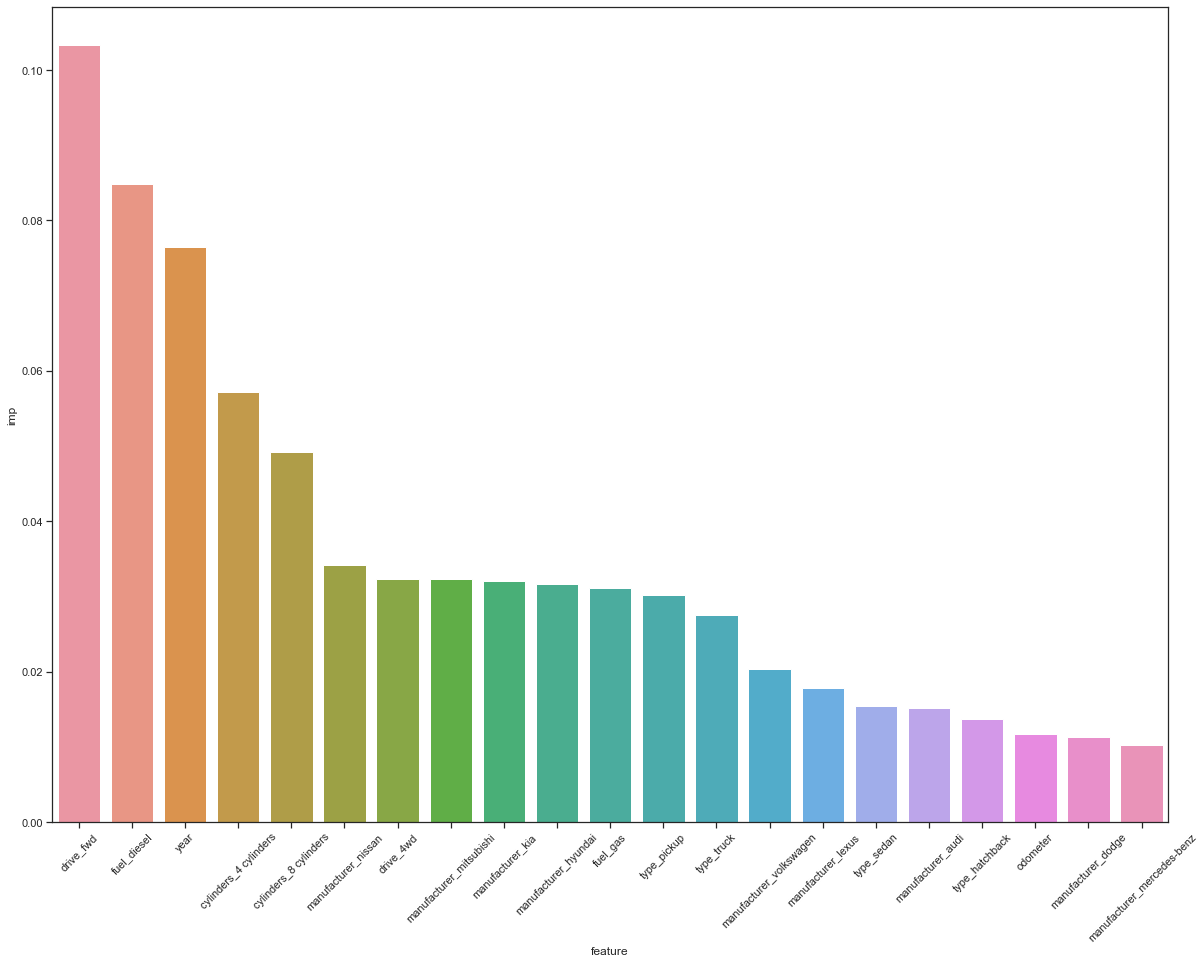

In [212]:
plt.figure(figsize=(20,15))
sns.barplot(data = importance.sort_values(ascending=False,by="imp")[0:21],x="feature", y= "imp")
plt.xticks(rotation=45)
plt.show()

In [ ]:
def objective(trial):


    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 10, 250)
    xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.1, 0.9, step =0.2)
    xgb_max_depth = trial.suggest_int("xgb_max_depth",1,5)

    classifier_obj = xgb.XGBRegressor(
        max_depth = xgb_max_depth,
        n_estimators = xgb_n_estimators,
        learning_rate = xgb_learning_ddrate,
        early_stopping_rounds = 50
    )

    splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=splitter)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-07-31 14:11:31,596] A new study created in memory with name: no-name-e3689080-dc01-4464-9190-c32dcc072b2c
[W 2022-07-31 14:11:38,954] Trial 0 failed, because the objective function returned nan.


In [168]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate,cross_val_score

In [194]:
from sklearn.ensemble import RandomForestRegressor

In [195]:
rfg = RandomForestRegressor()
rfg.fit(train_x,train_y)
rfg.score(test_x,test_y)

0.9815875280468965

In [196]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(rfg, x, y, n_jobs=-1, cv=splitter)

In [198]:
score.mean()

0.8749762886419093

In [199]:
rfg.score(test_x,test_y)

0.8712585890442146

In [202]:
importance = pd.DataFrame({"feature" : x.columns,'imp':rfg.feature_importances_})

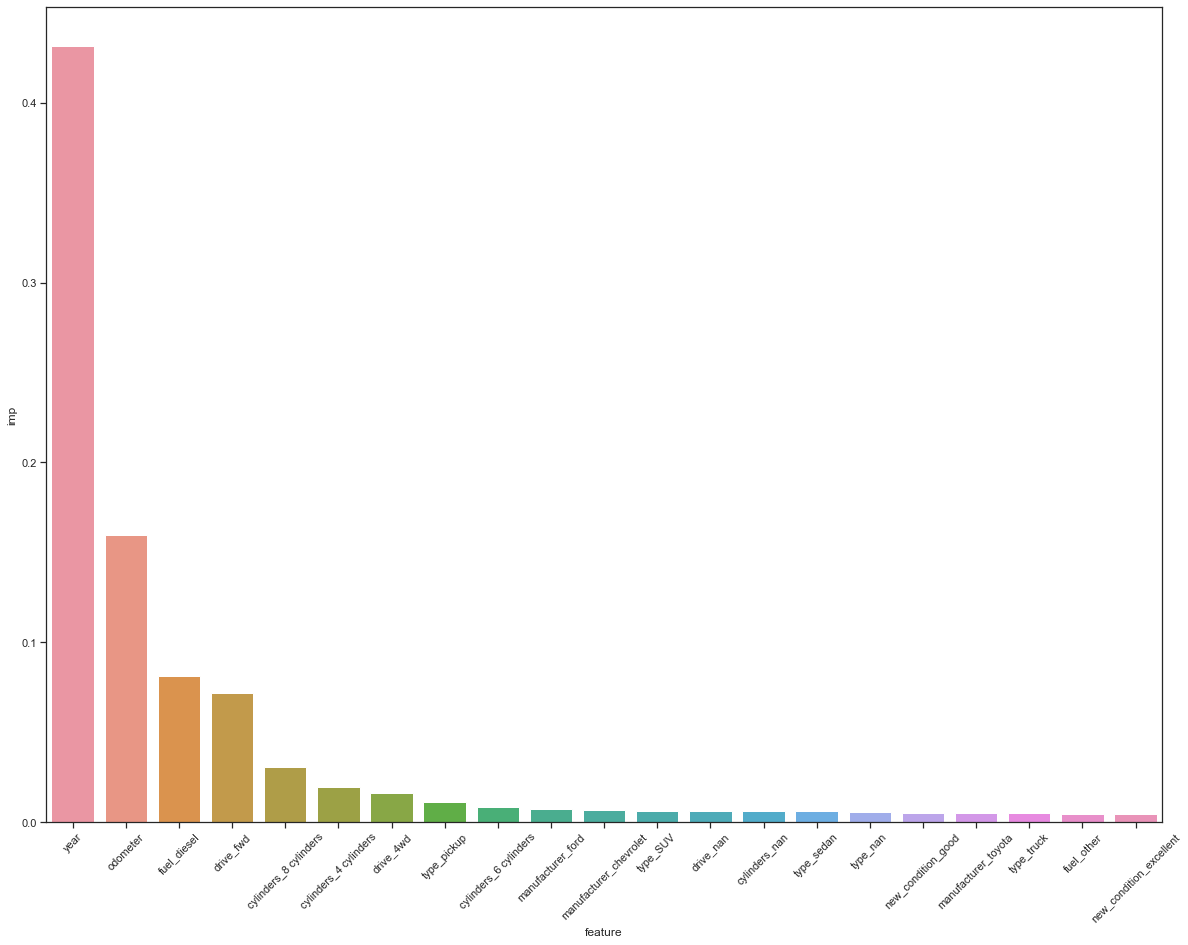

In [205]:
plt.figure(figsize=(20,15))
sns.barplot(data = importance.sort_values(ascending=False,by="imp")[0:21],x="feature", y= "imp")
plt.xticks(rotation=45)
plt.show()

In [214]:
final_data = pd.concat([x,y],axis=1)

In [216]:
final_data.to_csv("final_data.csv")